# Metropolitan bicycle sharing system:  How many bicycles need to be ready at a given time
## Regression Approach
Data was taken from https://www.kaggle.com/c/bike-sharing-demand/data in April 2020.       
Plots can be found in the notebook 'bikeSharing_visualPart'

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet

In [2]:
df = pd.read_csv('df_preprocessed.csv', index_col=None, parse_dates=True)
df.head()

,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,hour,...,year,summer,fall,winter,Monday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,0,1,9.84,81,0.0,3,13,16,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,9.02,80,0.0,8,32,40,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,9.02,80,0.0,5,27,32,2,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,9.84,75,0.0,3,10,13,3,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,9.84,75,0.0,0,1,1,4,...,0,0,0,0,0,0,0,0,1,0


## Data Transformation
#### Data Assignment

In [3]:
Xy = df[['holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
        'count', 'hour', 'month', 'year', 'summer', 'fall', 'winter', 'Monday', 
        'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
y = Xy['count']
X = Xy.drop(['count'], axis=1)

#### Polynomial Features

In [4]:
pf = PolynomialFeatures(interaction_only=False, degree=1)
data_X = pf.fit_transform(X)

#### Scaling

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['temp', 'humidity', 'windspeed', 'hour', 'month', 'year']] = scaler.fit_transform(df[['temp', 'humidity', 'windspeed', 'hour', 'month', 'year']])
df.tail()

,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,hour,...,year,summer,fall,winter,Monday,Wednesday,Thursday,Friday,Saturday,Sunday
10881,0,1,1,0.367347,0.50,0.456213,7,329,336,0.826087,...,1.0,0,0,1,0,1,0,0,0,0
10882,0,1,1,0.346939,0.57,0.263195,10,231,241,0.869565,...,1.0,0,0,1,0,1,0,0,0,0
10883,0,1,1,0.326531,0.61,0.263195,4,164,168,0.913043,...,1.0,0,0,1,0,1,0,0,0,0
10884,0,1,1,0.326531,0.61,0.105325,12,117,129,0.956522,...,1.0,0,0,1,0,1,0,0,0,0
10885,0,1,1,0.306122,0.66,0.157870,4,84,88,1.000000,...,1.0,0,0,1,0,1,0,0,0,0


#### Logarithmizing

#### Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=45883)

## Machine Learning: Try different regression models
#### LassoCV

In [7]:
alphas_values = np.array([3,2,1,0.075,0.05,0.025,0.1,0.01,0.005,0.001,0.0001])
lassoCV = LassoCV(alphas=alphas_values, n_jobs=-1, random_state=958)
parameter_grid_lassoCV={'cv': ([5,6,7,8,9,10,11,12])}
reg = GridSearchCV(estimator=lassoCV, param_grid=parameter_grid_lassoCV, n_jobs=-1)
reg.fit(X_train, y_train)

print('Best score:', reg.best_score_)
print('Best alphas: ', reg.best_estimator_.alpha_)
print('Best cv: ', reg.best_estimator_.cv)

Best score: 0.39388836456599013
Best alphas:  0.05
Best cv:  10


#### RidgeCV

In [8]:
alphas_values = np.array([500,300,100,50,20,10,5,3,2,1,0.1,0.01,0.001,0.0001])
ridgeCV = RidgeCV(alphas=alphas_values)
parameter_grid_ridgeCV={'cv': ([5,6,7,8,9,10,11,12])}
reg = GridSearchCV(estimator=ridgeCV, param_grid=parameter_grid_ridgeCV, n_jobs=-1)
reg.fit(X_train, y_train)

print('Best score:', reg.best_score_)
print('Best alphas: ', reg.best_estimator_.alpha_)
print('Best cv: ', reg.best_estimator_.cv)

Best score: 0.39382182746681627
Best alphas:  10.0
Best cv:  5


#### Elastic Net

In [9]:
eNet = ElasticNet()
parameter_grid_eNet={'alpha': ([50,10,5,3,2,1,0.075,0.05,0.025,0.1,0.01,0.005,0.001,0.0001]),
                     'l1_ratio': ([0.01, 0.25, 0.5, 0.75, 1])}
reg = GridSearchCV(estimator=eNet, param_grid=parameter_grid_eNet, n_jobs=-1)
reg.fit(X_train, y_train)

print('Best score:', reg.best_score_)
print('Best alpha: ', reg.best_estimator_.alpha)
print('Best l1_ratio: ', reg.best_estimator_.l1_ratio)

Best score: 0.39387066158507456
Best alpha:  0.05
Best l1_ratio:  1


### Cross Validation

In [10]:
def cross_val(model, m, X_train, y_train):
    cvValue_mean = []
    for i in range(5,15):       
        cross_val_L = cross_val_score(m, X_train, y_train, cv=i) 
        cvValue_mean.append([i,cross_val_L.mean()])
    df_cvValue_mean = pd.DataFrame(cvValue_mean)
    df_cvValue_mean.rename(columns={0:'cv_set_value', 1:'cv_res_mean'}, inplace = True)
    df_cvValue_mean.set_index(['cv_set_value'], inplace=True)
    print(df_cvValue_mean['cv_res_mean'].sort_values(ascending=False), '\n\n')

### Model Assignment

In [11]:
reg_models = [LinearRegression(n_jobs=-1),               
              LassoCV(alphas=[0.001,0.01,0.011], cv=10),
              RidgeCV(alphas=[2,3,4], cv=5),
              ElasticNet(alpha=0.1, l1_ratio=1)]
model_names = ['LinearRegression','LassoCV','RidgeCV','ElasticNet']
dict_m = {}    

### Fit and Predict

In [12]:
def fit_predict(bestModel, dict_yPred, modelName):
    m = bestModel
    m.fit(X_train, y_train)
    print(bestModel)
    print('Score(X_train, y_train): ', m.score(X_train, y_train))
    y_pred = m.predict(X_test) 
#     y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0         
    dict_yPred[modelName] = y_pred
    print('Score(X_test, y_test): ', m.score(X_test, y_test))   
    print('RMSLE: ', np.sqrt(mean_squared_log_error(y_test, y_pred)))
    cross_val(bestModel, m, X_train, y_train)
    
dict_y_pred={}
for i, elem in enumerate(reg_models,1):
    dict_m[model_names[i-1]] = fit_predict(elem, dict_y_pred, model_names[i-1])

LinearRegression(n_jobs=-1)
Score(X_train, y_train):  0.3974782967396586
Score(X_test, y_test):  0.38653780155080464
RMSLE:  1.2953979641124342
cv_set_value
7     0.394243
10    0.394196
8     0.394192
14    0.394097
9     0.393904
5     0.393812
6     0.393805
11    0.393734
12    0.393602
13    0.393520
Name: cv_res_mean, dtype: float64 


LassoCV(alphas=[0.001, 0.01, 0.011], cv=10)
Score(X_train, y_train):  0.397475762411559
Score(X_test, y_test):  0.3866638293701493
RMSLE:  1.2951066175735977
cv_set_value
7     0.394253
8     0.394206
10    0.394200
14    0.394111
9     0.393912
5     0.393828
6     0.393810
11    0.393743
12    0.393606
13    0.393527
Name: cv_res_mean, dtype: float64 


RidgeCV(alphas=array([2, 3, 4]), cv=5)
Score(X_train, y_train):  0.39747418231630904
Score(X_test, y_test):  0.38666440327643337
RMSLE:  1.294946963037595
cv_set_value
7     0.394271
8     0.394219
10    0.394218
14    0.394120
9     0.393921
6     0.393830
5     0.393826
11    0.393757
12    0.39

In [13]:
rmsle=[]   
for reg in reg_models:    
    reg.fit(X_train,y_train)
    y_pred=abs(reg.predict(X_test))
#     y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0 
    if len(np.array(y_pred)[np.array(y_pred)< 0]) > 0 :
        print(reg)
        print('count of negative values: ', len(np.array(y_pred)[np.array(y_pred)< 0]),'\n')    
    rmsle.append(np.sqrt(mean_squared_log_error(y_pred,y_test)))            
dict_rmsle={'Regression_Model':model_names,'RMSLE':rmsle}   
dict_rmsle
df_rmsle=pd.DataFrame(dict_rmsle)
df_rmsle

,Regression_Model,RMSLE
0,LinearRegression,1.222160
1,LassoCV,1.222800
2,RidgeCV,1.222452
3,ElasticNet,1.221137


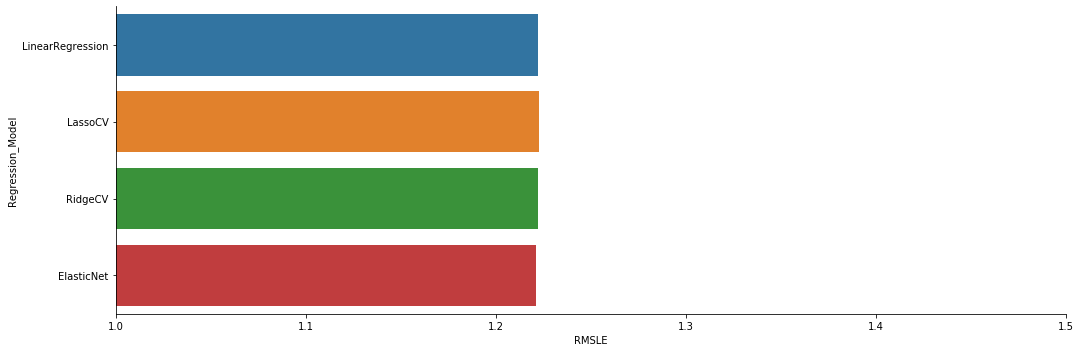

In [14]:
fig = sns.catplot(y='Regression_Model', x='RMSLE', data=df_rmsle,
                  kind='bar',height=5,aspect=3)
fig.set(xlim=(1.0, 1.5))